# Structure factor
This notebook calculates the structure factor from two file trajectories. To illustrate the process of obtaining it, the first frame of one of the trajectory files is first visualised directly, then again after coarse graining and then finally with the cubic density matrix used in the FFT. These routines are then applied for all frames of both trajectories to obtain comparable curves for S(q).

In [1]:
%load_ext lab_black

A collection of helper functions are defined in the notebook helper_functions.ipynb.

In [2]:
%run helper_functions2.ipynb

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
trajectory = {
    "Heterogenous": "simulation_data/data4000_heter_20220818.txt",
    "Homogenous": "simulation_data/homogeneity_core_only.xyz",
}

## Visualize the first frame of the first trajectory file
A trajectory file for a heterogenous state is read into the array coords. L is the box-length in each dimension, and ntimesteps is the number of snapshots in the trajectory. It should be interactive, but it might be a bit slow.

In [4]:
coords, L, ntimesteps = read_trajectory_custom(trajectory["Heterogenous"])
pl = visualize_points_directly(coords[0], L)

2413 atoms and 11 timesteps


BokehModel(combine_events=True, render_bundle={'docs_json': {'d248d3a7-32ee-4155-a3c4-8bc32fb7bd93': {'defs': …

### Coarse grain first frame and visualize again

In [5]:
coords_cg, particle_radius = coarsegrain(coords[0], L)
cx, cy, cz = coords_cg

In [6]:
pl = visualize_points_directly(coords[0], L, opacity=0.5, show=False)
pl = visualize_points_directly(coords_cg, L, pl=pl, opacity=1, color="red")

BokehModel(combine_events=True, render_bundle={'docs_json': {'94125275-2bfc-486a-9d77-a83f67114260': {'defs': …

### Shift and rescale the coordinates to match up with the cubic density-matrix and visualize again
Instead of plotting the coordinates, ranging from -L/2 to L/2 along each axis, we now plot the index in the density matrix, ranging from 0 to N. The particles is shown together with the density. Zooming in and out, the density matrix should match up with the particle coordinates, or the periodic image of the coordinates

In [7]:
N = 128
pl = visualize_points(
    [cx, cy, cz], N, L, radius=1, show=False, color="red", opacity=0.5
)
rho = map_trajectory_delta(N, L, cx, cy, cz)
visualize_density_matrix(rho, pl)

BokehModel(combine_events=True, render_bundle={'docs_json': {'0ee5d7e3-63ce-441f-a32f-61401930a963': {'defs': …

This cubic density matrix is then fourier-transformed to obtain the scattering intensity and the structure factor.

## Function to get S(q)
Function to get the structure factor from a trajectory

In [8]:
def get_s_of_q(coords, L, N=128, do_coarsegraining=True, osc_convention=2 * np.pi):
    # Average magnitude of the fourier-transform of the density
    avg_rho_hat_magnitude = np.zeros(
        (N // 2, N // 2, N // 2 + 1), dtype=numpy_float_precision
    )

    # Loop over all timesteps in trajectory-file
    for t in trange(ntimesteps):

        # Arrays for coordinates along x, y and z for timestep t
        cx, cy, cz = coords[t]

        if do_coarsegraining:
            coords_cg, particle_radius = coarsegrain(coords[t], L)
            cx, cy, cz = coords_cg
        natoms = len(cx)

        # Map trajectory to N x N x N cubic density matrix
        rho = map_trajectory_delta(N, L, cx, cy, cz)

        # Check that the integral of the density matrix is reasonably close to natoms (manually)
        print(integrate(rho, dx=L / N), natoms)

        # Do 3D FFT
        rho_hat = np.fft.rfftn(rho)

        # Get magnitude
        rho_hat_magnitude = np.real(rho_hat * rho_hat.conjugate())

        # Average and discard negative frequencies due to symmetry
        # Divide by natoms inside this loop, as the coarsegraining may change the number of particles
        avg_rho_hat_magnitude += rho_hat_magnitude[: N // 2, : N // 2, :] / natoms

    # Divide by the number of timesteps to get the average values
    avg_rho_hat_magnitude /= ntimesteps

    # Calculate histogram of I(q)
    q_hist, intensity_hist, intensity_std = calculate_intensity(
        avg_rho_hat_magnitude, N, L, osc_convention
    )

    return q_hist, intensity_hist, intensity_std

## Calculate S(q) for both trajectory files

In [9]:
# store q, S(q) and the standard deviation of S(q) in dictionaries
q = {}
s = {}
s_std = {}

# Loop over the dictionary of trajectories, run the function above and store the output in the dictionaries above
for label, filename in trajectory.items():
    print(f"Calculating S(q) for {label} trajectory")
    coords, L, ntimesteps = read_trajectory_custom(filename)
    q[label], s[label], s_std[label] = get_s_of_q(coords, L)

Calculating S(q) for Heterogenous trajectory
2413 atoms and 11 timesteps


  9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

13.623724416212257 95


 18%|█▊        | 2/11 [00:02<00:11,  1.27s/it]

13.33690916534463 93


 27%|██▋       | 3/11 [00:03<00:09,  1.25s/it]

13.33690916534463 93


 36%|███▋      | 4/11 [00:04<00:08,  1.24s/it]

13.193501539910818 92


 45%|████▌     | 5/11 [00:06<00:07,  1.29s/it]

13.050093914477005 91


 55%|█████▍    | 6/11 [00:07<00:06,  1.27s/it]

13.050093914477005 91


 64%|██████▎   | 7/11 [00:08<00:05,  1.26s/it]

13.050093914477005 91


 73%|███████▎  | 8/11 [00:10<00:03,  1.29s/it]

13.050093914477005 91


 82%|████████▏ | 9/11 [00:11<00:02,  1.27s/it]

12.906686289043192 90


 91%|█████████ | 10/11 [00:12<00:01,  1.26s/it]

12.906686289043192 90


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]

12.906686289043192 90


Calculating S(q) for Homogenous trajectory
3000 atoms and 11 timesteps


  9%|▉         | 1/11 [00:01<00:13,  1.33s/it]

15.874495309822603 108


 18%|█▊        | 2/11 [00:02<00:11,  1.31s/it]

15.874495309822603 108


 27%|██▋       | 3/11 [00:03<00:10,  1.30s/it]

15.874495309822603 108


 36%|███▋      | 4/11 [00:05<00:09,  1.37s/it]

15.874495309822603 108


 45%|████▌     | 5/11 [00:06<00:08,  1.35s/it]

15.874495309822603 108


 55%|█████▍    | 6/11 [00:07<00:06,  1.33s/it]

15.874495309822603 108


 64%|██████▎   | 7/11 [00:09<00:05,  1.31s/it]

15.874495309822603 108


 73%|███████▎  | 8/11 [00:10<00:03,  1.30s/it]

15.874495309822603 108


 82%|████████▏ | 9/11 [00:11<00:02,  1.29s/it]

15.874495309822603 108


 91%|█████████ | 10/11 [00:13<00:01,  1.29s/it]

15.874495309822603 108


100%|██████████| 11/11 [00:14<00:00,  1.32s/it]

15.874495309822603 108


### Make a figure comparing S(q) for the two trajectories

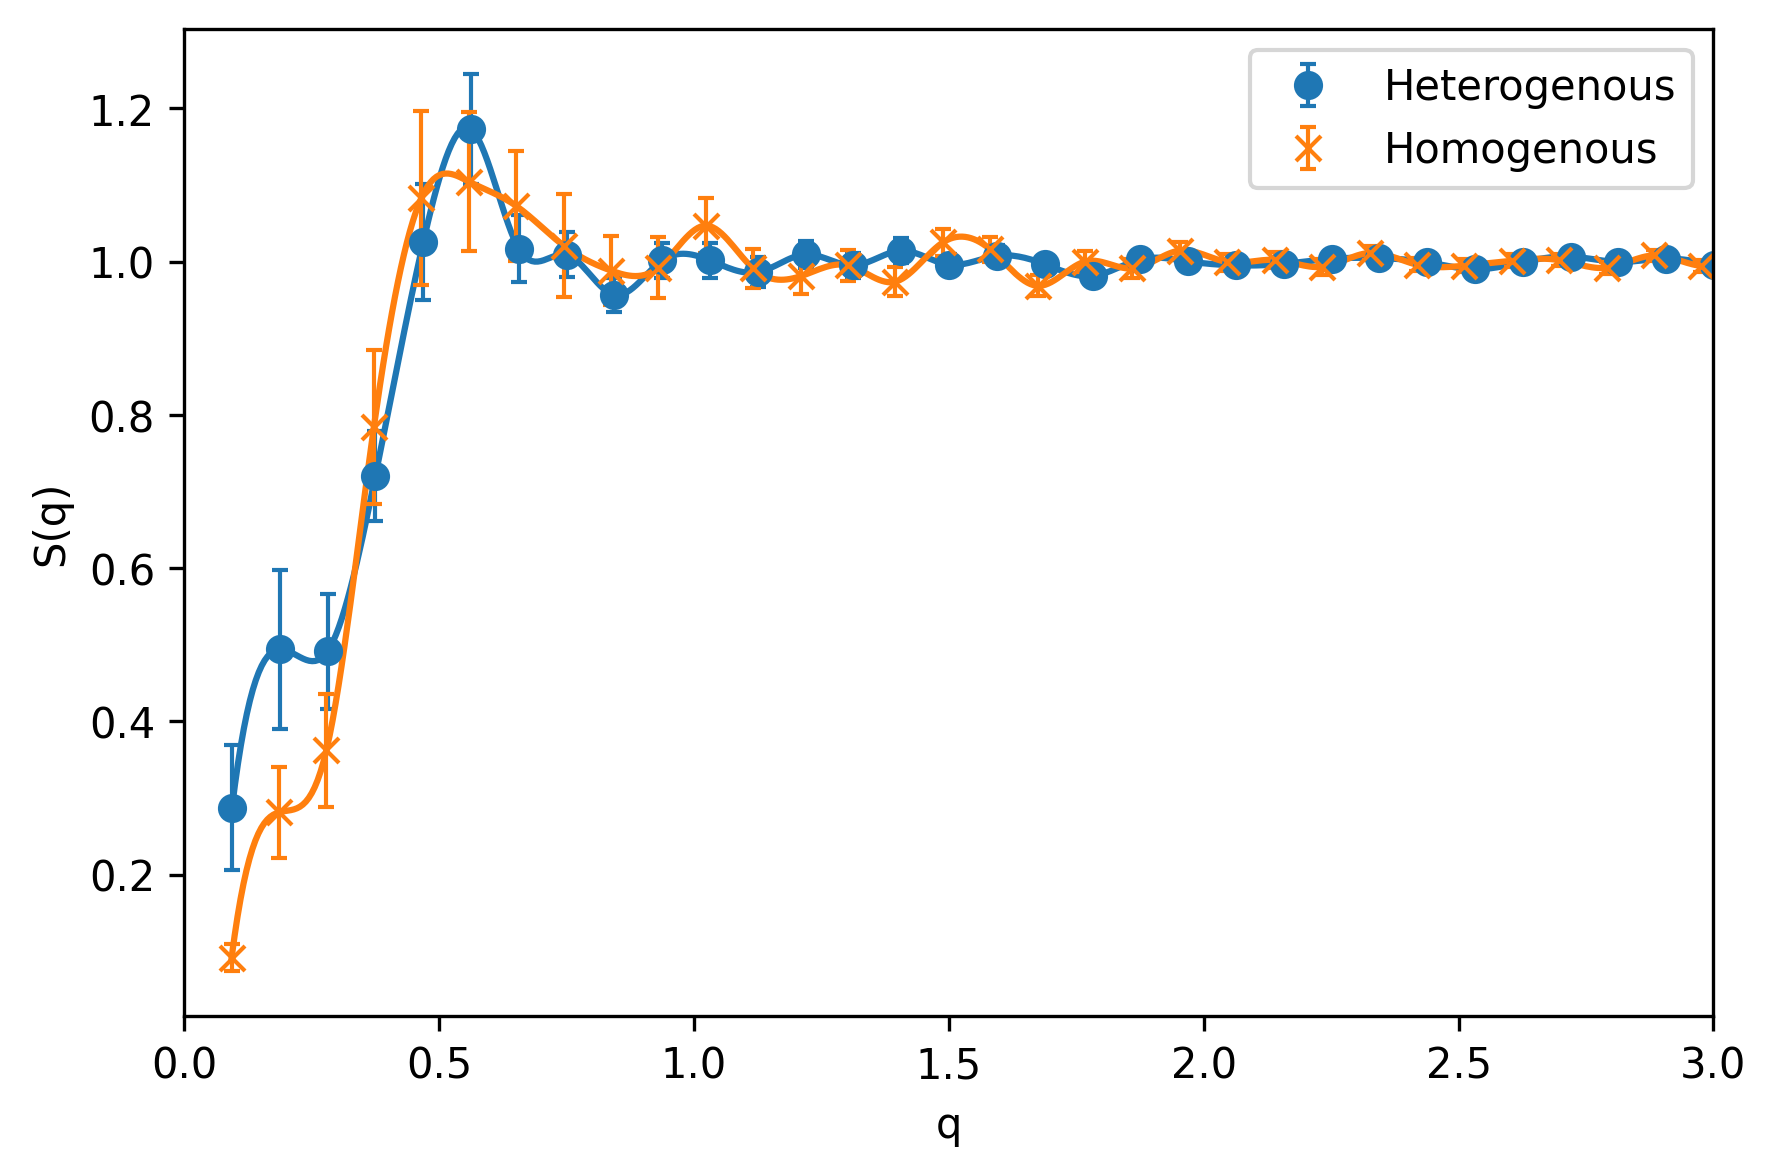

In [10]:
ax = None
markers = ["o", "x"]
colors = ["tab:blue", "tab:orange"]
for i, label in enumerate(trajectory.keys()):
    ax = make_figure_s(
        q[label],
        s[label],
        s_std[label],
        label=label,
        marker=markers[i],
        color=colors[i],
        spline=True,
        ax=ax,
        show=False,
    )

plt.legend()
plt.tight_layout(pad=1.0)